In [19]:
import transformers
print(transformers.__version__)

4.41.0


In [20]:
model_checkpoint = "antoineedy/stanford-deidentifier-base-finetuned-ner"
batch_size = 16

In [21]:
from datasets import load_dataset, load_metric

In [22]:
datasets = load_dataset("surrey-nlp/PLOD-CW")

In [23]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "B-LF": 2,
    "I-LF": 3,
}

datasets = datasets.map(lambda x: {"ner_tags": [TEXT2ID[tag] for tag in x["ner_tags"]]})

In [24]:
label_list = list(set(datasets["train"]['ner_tags'][0]))
label_list

[0, 1, 2, 3]

In [25]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

In [27]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [28]:
label_all_tokens = True

In [29]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [30]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 153/153 [00:00<00:00, 8083.24 examples/s]


In [31]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), ignore_mismatched_sizes=True)

In [32]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ner",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=60,
    weight_decay=0.01,
    push_to_hub=True,
)

/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [34]:
metric = load_metric("seqeval")

/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [35]:
example = datasets["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'for',
 'this',
 'purpose',
 'the',
 'got',
 '##hen',
 '##burg',
 'young',
 'persons',
 'empowerment',
 'scale',
 '(',
 'gy',
 '##pes',
 ')',
 'was',
 'developed',
 '.',
 '[SEP]']

In [36]:
labels = [label_list[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/c

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 1.0}

In [37]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

from sklearn.metrics import classification_report
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    tp = []
    for l in true_predictions:
        tp += l
    tl = []
    for l in true_labels:
        tl += l

    cr = classification_report(tl, tp, output_dict=True)
    out = {}
    for key in cr.keys():
        if key == 'accuracy':
            out[key] = cr[key]
        else:
            for new_k in ['precision', 'recall', 'f1-score']:
                out[key+'_'+new_k] = cr[key][new_k]
    return out

In [38]:
import torch
from torch import nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        w3 = [0.0443, 0.6259, 1.0000, 0.4525]
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(w3).to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the `train` method:

In [39]:
#trainer.train()

In [40]:
trainer.evaluate()

100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


{'eval_loss': 0.6521803736686707,
 'eval_0_precision': 0.9766486486486486,
 'eval_0_recall': 0.9645526371983771,
 'eval_0_f1-score': 0.9705629565964762,
 'eval_1_precision': 0.8267898383371824,
 'eval_1_recall': 0.8689320388349514,
 'eval_1_f1-score': 0.8473372781065088,
 'eval_2_precision': 0.8418604651162791,
 'eval_2_recall': 0.8916256157635468,
 'eval_2_f1-score': 0.8660287081339713,
 'eval_3_precision': 0.8393782383419689,
 'eval_3_recall': 0.8975069252077562,
 'eval_3_f1-score': 0.8674698795180723,
 'eval_accuracy': 0.950698003180774,
 'eval_macro avg_precision': 0.8711692976110198,
 'eval_macro avg_recall': 0.9056543042511579,
 'eval_macro avg_f1-score': 0.8878497055887571,
 'eval_weighted avg_precision': 0.9521463603952284,
 'eval_weighted avg_recall': 0.950698003180774,
 'eval_weighted avg_f1-score': 0.9512651950129704,
 'eval_runtime': 4.8671,
 'eval_samples_per_second': 25.888,
 'eval_steps_per_second': 1.644}

In [41]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/antoine

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.950698003180774}

In [42]:
print(true_labels)

labels = []
for l in true_labels:
  labels+=l
pred = []
for l in true_predictions:
  pred += l

ID2TEXT = {
    0: "B-O",
    1: "B-AC",
    2: "B-LF",
    3: "I-LF"
}
TEXT2ID = {v: k for k, v in ID2TEXT.items()}
labels = [ID2TEXT[k] for k in labels]
pred = [ID2TEXT[k] for k in pred]
print(labels)

[[0, 2, 3, 3, 3, 0, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 3, 3, 0, 1, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0

findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Fo

['B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O',

findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Font family 'Liberation Serif' not found.
findfont: Fo

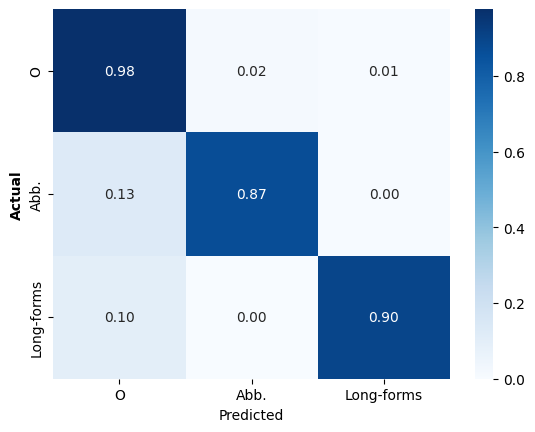

In [43]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

alabels = ['B-O', 'B-AC', 'B-LF']
nlabels = ['O', 'Abb.', 'Long-forms']

c = labels
p = pred

print(c, '\n', p)

cm = confusion_matrix(c, p, normalize='true', labels =alabels)

plt.style.use('default')

plt.figure(dpi=100)

# change font to scientific
plt.rcParams['font.family'] = 'Liberation Serif'

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=nlabels, yticklabels=nlabels, fmt=".2f")
#make labels bold
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted')
plt.show()

In [44]:
trainer.push_to_hub("new_test")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin: 100%|██████████| 5.18k/5.18k [00:00<00:00, 15.7kB/s]
Upload 2 LFS files:   0%|          | 0/2 [00:13<?, ?it/s]
